# Модель выбытия жилищного фонда

In [9]:
from os import path, getcwd

import pandas as pd
import numpy as np
import sqlalchemy as sa
import re
import matplotlib.pyplot as plt

strDB_path=path.join('oljiaSHORT.sqlite3')

# константы базы данных SQLite3
strHouse_table='houses' # название таблицы NOZA в базе данных SQLite
strHouse_data_pass='houses_columns' # таблица с названиями колонок для таблицы noza

## Данные из БД 

In [10]:
strSELECT_House='select * from {house_table}'.format(house_table=strHouse_table)

conWork = sa.create_engine('sqlite+pysqlite:///{db_name}'.format(db_name=strDB_path)) # connection к рабочей базе данных

pdfHouse=pd.read_sql(strSELECT_House, con=conWork)

Обработка панели

In [11]:
# pdfHouse.dropna(subset=['house_type'])
wdf = pdfHouse.copy()
# wdf = wdf[wdf['built_year'].notna()].sort_values(by=['built_year'])
wdf = wdf.sort_values(by=['built_year']) #.dropna(subset=['living_quarters_count','house_type','area_residential','area_total']) subset=['living_quarters_count','house_type','area_residential','area_total']
wdf = wdf[(wdf['built_year'] >= 1801) & (wdf['built_year'] <= 2019)]
#           &((wdf['house_type'] == 'Многоквартирный дом') | (wdf['house_type'] == 'Жилой дом блокированной застройки'))]
# pdfHouse.dropna()
# tdf[tdf['is_alarm','wall_material','house_type'].notna()]
wdf.reset_index(drop=True,inplace=True)
wdf

,houseguid,built_year,house_type,is_alarm,floor_count_max,elevators_count,area_total,area_residential,foundation_type,floor_type,wall_material,heating_type,hot_water_type,cold_water_type,living_quarters_count
0,8df065e7-1bba-4a5e-b1ca-0e84b3b1359c,1801.0,None,Нет,2.0,NaN,169.0,164.9,None,None,None,None,None,None,5.0
1,0dc1ad4f-e383-40f2-9067-6c1122bc4643,1801.0,Многоквартирный дом,Нет,3.0,0.0,616.7,236.6,None,Деревянные,Кирпич,Центральное,Отсутствует,Центральное,NaN
2,ded84f7a-7994-44c9-9064-70b88b91f076,1801.0,Многоквартирный дом,Нет,4.0,0.0,550.3,231.3,Ленточный,Деревянные,Кирпич,Центральное,Закрытая с приготовлением горячей воды на ЦТП,Центральное,15.0
3,f8078873-01a8-420f-a07a-f2179620afcc,1802.0,Многоквартирный дом,Нет,5.0,0.0,8946.0,5265.0,Ленточный,Смешанные,Кирпич,Центральное,Открытая с отбором сетевой воды на горячее вод...,Центральное,0.0
4,e4c23e92-615d-4e1c-93b9-4d10e76c3ca3,1802.0,Многоквартирный дом,Нет,2.0,0.0,542.1,435.9,Ленточный,Деревянные,Кирпич,Центральное,Открытая с отбором сетевой воды на горячее вод...,Центральное,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679983,2afa1b79-645b-416f-88ba-7487c70b8273,2019.0,Многоквартирный дом,Нет,20.0,4.0,12479.5,8239.3,Свайный,Железобетонные,Железобетонная панель,Индивидуальный тепловой пункт (ИТП),Закрытая с приготовлением горячей воды на ИТП,Центральное,219.0
679984,7ca3ed9d-ccf3-440e-bbda-7a680a20433e,2019.0,None,Нет,17.0,2.0,9579.7,7241.2,None,None,None,None,None,None,153.0
679985,e9378f1a-1659-4236-86ff-0c20dc646556,2019.0,None,Нет,14.0,4.0,14226.0,8720.9,None,None,None,None,None,None,139.0
679986,d8287c8c-61b0-40c3-8997-642a72f67c87,2019.0,Многоквартирный дом,Нет,32.0,14.0,56107.4,43597.9,Сплошной,Железобетонные,Монолитные,Индивидуальный тепловой пункт (ИТП),Закрытая с приготовлением горячей воды на ЦТП,Центральное,894.0


In [12]:
wdf['house_type'].unique()

array([None, 'Многоквартирный дом', 'Специализированный жилищный фонд',
       'Жилой дом блокированной застройки',
       'Жилой дом (индивидуально-определенное здание)'], dtype=object)

In [13]:
# Оставляем только МКД и Жилые дома блокированной застройки (НУЖНО ВООБЩЕ ТОЛЬКО МКД!!!!!!!)
wdf=wdf[(wdf['house_type']=='Многоквартирный дом')|
        (wdf['house_type']=='Жилой дом блокированной застройки')]

Суммарные площади (влючая строки с пропусками в данных этажности):

In [35]:
Tot_sq   = wdf.dropna(subset=['house_type','is_alarm','wall_material'])['area_total'].sum()/1000000
House_sq = wdf.dropna(subset=['house_type','is_alarm','wall_material'])['area_residential'].sum()/1000000

print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq, b=House_sq))

Общая площадь, млн кв. м.: 2451.943543109999
Жилая площадь, млн кв. м.: 1927.2046943100004


Суммарные площади (НЕ включаем строки с пропусками в данных этажности):

In [34]:
Tot_sq_flr   = wdf.dropna(subset=['house_type','is_alarm','wall_material', 'floor_count_max'])['area_total'].sum()/1000000
House_sq_flr = wdf.dropna(subset=['house_type','is_alarm','wall_material', 'floor_count_max'])['area_residential'].sum()/1000000

print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq_flr, b=House_sq_flr))

Общая площадь, млн кв. м.: 2449.63923059
Жилая площадь, млн кв. м.: 1925.7072482299995


Суммарные площади (исключаем пропуски только "is_alarm" и "house_type"):

In [16]:
Tot_sq_alarm   = wdf.dropna(subset=['house_type','is_alarm'])['area_total'].sum()/1000000
House_sq_alarm = wdf.dropna(subset=['house_type','is_alarm'])['area_residential'].sum()/1000000
print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq_alarm, b=House_sq_alarm))

Общая площадь, млн кв. м.: 2484.79855357
Жилая площадь, млн кв. м.: 1952.0569250600001


## Условия

In [17]:
cond1=pd.Series({'Доля учитываемого фонда': 1, 
                 'Возраст': 50,
                 'Аварийный': 'Нет', 
                 'Несущие стены': 'Деревянные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 1')
cond2=pd.Series({'Доля учитываемого фонда': 0.7,
                 'Возраст': 60, 
                 'Этажность (от)': 1,
                 'Этажность (до)': 5,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Панельные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 2')
cond3=pd.Series({'Доля учитываемого фонда': 0.5,
                 'Возраст': 80, 
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Смешанные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 3')
cond4=pd.Series({'Доля учитываемого фонда': 0.5,
                 'Возраст': 60,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Иные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 4')
cond5=pd.Series({'Доля учитываемого фонда': 0.3,
                 'Возраст': 100,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Блочные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 5')
cond6=pd.Series({'Доля учитываемого фонда': 0.3,
                 'Возраст': 100, 
                 'Этажность (от)': 1,
                 'Этажность (до)': 5,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Кирпич', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 6')
cond7=pd.Series({'Доля учитываемого фонда': 0.1,
                 'Возраст': 100, 
                 'Этажность (от)': 6,
                 'Этажность (до)': 50,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Кирпич', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 7')
cond8=pd.Series({'Доля учитываемого фонда': 0.5,
                 'Возраст': 100, 
                 'Этажность (от)': 6,
                 'Этажность (до)': 50,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Панельные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 8')
cond9=pd.Series({'Доля учитываемого фонда': 0.1,
                 'Возраст': 150,
                 'Аварийный': 'Нет',
                 'Несущие стены': 'Монолитные', 
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 9')
cond10=pd.Series({'Аварийный': 'Да',
                 'Тип дома': 'Многоквартирный дом'}, name='Условие 10')

Cond_df=pd.DataFrame([cond1,cond2,cond3,cond4,cond5,cond6,cond7,cond8,cond9,cond10])

In [18]:
Cond_df.rename(columns={'Доля учитываемого фонда': 'share',
                        'Возраст':'age',
                        'Аварийный':'is_alarm',
                        'Несущие стены':'wall_material', 
                        'Тип дома':'house_type',
                        'Этажность (от)':'floor_0', 
                        'Этажность (до)':'floor_1' }, 
               index=dict(zip(Cond_df.index,[i.replace('Условие ','cond') for i in Cond_df.index])), inplace = True)

In [19]:
Cond_df

,share,age,is_alarm,wall_material,house_type,floor_0,floor_1
cond1,1.0,50.0,Нет,Деревянные,Многоквартирный дом,NaN,NaN
cond2,0.7,60.0,Нет,Панельные,Многоквартирный дом,1.0,5.0
cond3,0.5,80.0,Нет,Смешанные,Многоквартирный дом,NaN,NaN
cond4,0.5,60.0,Нет,Иные,Многоквартирный дом,NaN,NaN
cond5,0.3,100.0,Нет,Блочные,Многоквартирный дом,NaN,NaN
cond6,0.3,100.0,Нет,Кирпич,Многоквартирный дом,1.0,5.0
cond7,0.1,100.0,Нет,Кирпич,Многоквартирный дом,6.0,50.0
cond8,0.5,100.0,Нет,Панельные,Многоквартирный дом,6.0,50.0
cond9,0.1,150.0,Нет,Монолитные,Многоквартирный дом,NaN,NaN
cond10,NaN,NaN,Да,NaN,Многоквартирный дом,NaN,NaN


Жилая площадь, по состоянию на I полугодие 2019 г.:

In [20]:
xxx=2336.932963

## Working in final DF using conditions

create empty dataframe

In [21]:
w_cols=list(range(2015, 2036))
idx=['cond'+str(i) for i in range(1,11)]

In [22]:
fdf=pd.DataFrame(columns=w_cols, index=idx)

fill it, using conditions from above

In [23]:
# for i, row in Cond_df.iterrows():
#     a=row.to_list()
#     print(a[2:])   

#     b=row.to_dict()
#     print(b)
    
#     b1 = {k: b[k] for k in b if pd.notna(b[k])}
#     b1.pop('share', None)
# #     keys_to_extract = ['is_alarm','wall_material','house_type']
# #     b1_subset = {k: b1[k] for k in keys_to_extract}
#     print(b1)
#     print('age' in b1.keys())
#     print(pd.notna(b['age']))

In [24]:
for i, row in Cond_df.iterrows():
    b=row.to_dict()
    b1 = {k: b[k] for k in b if pd.notna(b[k])}
    b1.pop('share', None)
    print(b1)
    
    for col in fdf.columns:
        if ('age' in b1) and ('floor_0' not in b1):
            fdf.loc[i,col] = wdf[(wdf['is_alarm']      == b['is_alarm']) & 
                                 (wdf['wall_material'] == b['wall_material']) & 
                                 (wdf['house_type']    == b['house_type']) &
                                 (col-wdf['built_year']>= b['age'])]['area_residential'].sum()/1000000 * xxx / House_sq * b['share']
        elif ('age' in b1) and ('floor_0' in b1):
            fdf.loc[i,col] = wdf[(wdf['is_alarm']      == b['is_alarm']) & 
                                 (wdf['wall_material'] == b['wall_material']) & 
                                 (wdf['house_type']    == b['house_type']) &
                                 (wdf['floor_count_max'].between(b['floor_0'],b['floor_1'])) &
                                 (col-wdf['built_year']>= b['age'])]['area_residential'].sum()/1000000 * xxx / House_sq_flr * b['share']
        else:
            fdf.loc[i,col] = wdf[(wdf['is_alarm']      == b['is_alarm']) & 
                                 (wdf['house_type']    == b['house_type'])]['area_residential'].sum()/1000000 * xxx / House_sq_alarm

fdf.loc['Total']=fdf.sum()

{'age': 50.0, 'is_alarm': 'Нет', 'wall_material': 'Деревянные', 'house_type': 'Многоквартирный дом'}
{'age': 60.0, 'is_alarm': 'Нет', 'wall_material': 'Панельные', 'house_type': 'Многоквартирный дом', 'floor_0': 1.0, 'floor_1': 5.0}
{'age': 80.0, 'is_alarm': 'Нет', 'wall_material': 'Смешанные', 'house_type': 'Многоквартирный дом'}
{'age': 60.0, 'is_alarm': 'Нет', 'wall_material': 'Иные', 'house_type': 'Многоквартирный дом'}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Блочные', 'house_type': 'Многоквартирный дом'}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Кирпич', 'house_type': 'Многоквартирный дом', 'floor_0': 1.0, 'floor_1': 5.0}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Кирпич', 'house_type': 'Многоквартирный дом', 'floor_0': 6.0, 'floor_1': 50.0}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Панельные', 'house_type': 'Многоквартирный дом', 'floor_0': 6.0, 'floor_1': 50.0}
{'age': 150.0, 'is_alarm': 'Нет', 'wall_material': 'Монолитные', 'house_type':

In [25]:
fdf

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
cond1,9.34215,9.57903,9.82567,10.1007,10.3586,10.6438,10.8633,11.0806,11.2969,11.515,...,11.9524,12.1533,12.3855,12.62,12.9133,13.1651,13.4579,13.8009,14.1052,14.4564
cond2,0.465691,0.546456,0.713911,1.05665,1.60964,3.02294,5.74194,10.058,15.4078,21.7082,...,37.1337,45.4637,54.2845,62.6981,71.632,80.2909,89.5933,99.0261,108.428,117.472
cond3,0.589838,0.602893,0.646495,0.656133,0.671222,0.685506,0.692259,0.694228,0.695229,0.697849,...,0.742774,0.759767,0.802362,0.856007,0.953248,1.02691,1.17504,1.29271,1.4229,1.53944
cond4,1.18401,1.34731,1.52947,1.79454,2.09883,2.42196,2.76028,3.16659,3.59349,3.93737,...,4.52737,4.92572,5.56665,6.24012,6.80073,7.35003,8.05759,8.7048,9.2629,9.83749
cond5,0.0237507,0.0237507,0.0373752,0.0378104,0.0383036,0.0387219,0.0387571,0.0387571,0.0389858,0.0390482,...,0.0435001,0.0449365,0.0480546,0.0509389,0.0564542,0.0663619,0.0757525,0.0827552,0.091864,0.103348
cond6,3.38061,3.54668,4.75034,4.79139,4.79622,4.80563,4.80726,4.81521,4.82548,4.83963,...,4.95727,5.0763,5.25434,5.48265,5.85576,6.10499,6.41483,6.61429,6.86142,7.09411
cond7,0.599469,0.620356,0.675904,0.675904,0.675904,0.676409,0.676409,0.676409,0.677382,0.681832,...,0.701506,0.723425,0.752419,0.775276,0.787623,0.803222,0.819849,0.835917,0.853371,0.868685
cond8,0.0419674,0.0419674,0.0419674,0.0419674,0.0419674,0.0419674,0.0419674,0.0484751,0.0484751,0.0484751,...,0.0484751,0.0484751,0.0484751,0.049482,0.0511055,0.0511055,0.0528087,0.073758,0.073758,0.0749336
cond9,0.000723875,0.000723875,0.000723875,0.000723875,0.000723875,0.000771167,0.000771167,0.000771167,0.000771167,0.000771167,...,0.00101757,0.00101757,0.00101757,0.00101757,0.00136875,0.00136875,0.00136875,0.00136875,0.00136875,0.00136875
cond10,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,...,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925,25.0925


## Сверяем со старыми данными

In [26]:
tdf=pd.read_excel('try.xlsx') #старая БД из Олиного экселя
tdf.replace(['Не заполнено','Нет данных','нет данных'], np.nan, inplace=True)

In [27]:
Tot_sq_t   = tdf.dropna(subset=['is_alarm','wall_material'])['area_total'].sum()/1000000
House_sq_t = tdf.dropna(subset=['is_alarm','wall_material'])['area_residential'].sum()/1000000

print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq_t, b=House_sq_t))

Общая площадь, млн кв. м.: 2371.881422
Жилая площадь, млн кв. м.: 1839.983162


In [28]:
Tot_sq_flr_t   = tdf.dropna(subset=['is_alarm','wall_material', 'FLR'])['area_total'].sum()/1000000
House_sq_flr_t = tdf.dropna(subset=['is_alarm','wall_material', 'FLR'])['area_residential'].sum()/1000000

print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq_flr_t, b=House_sq_flr_t))

Общая площадь, млн кв. м.: 2370.168925
Жилая площадь, млн кв. м.: 1838.695907


In [29]:
Tot_sq_alarm_t   = tdf['area_total'].sum()/1000000
House_sq_alarm_t = tdf['area_residential'].sum()/1000000
print('Общая площадь, млн кв. м.: {a}\nЖилая площадь, млн кв. м.: {b}'.format(a=Tot_sq_alarm_t, b=House_sq_alarm_t))

Общая площадь, млн кв. м.: 2400.224411
Жилая площадь, млн кв. м.: 1861.00693


In [30]:
fdf2=pd.DataFrame(columns=w_cols, index=idx)

In [31]:
for i, row in Cond_df.iterrows():
    b=row.to_dict()
    b1 = {k: b[k] for k in b if pd.notna(b[k])}
    b1.pop('share', None)
    print(b1)
    
    for col in fdf2.columns:
        if ('age' in b1) and ('floor_0' not in b1):
            fdf2.loc[i,col] = tdf[(tdf['is_alarm']       == b['is_alarm']) & 
                                  (tdf['wall_material']  == b['wall_material']) & 
                                  (tdf['house_type']     == b['house_type']) &
                                  (col-tdf['built_year'] >= b['age'])]['area_residential'].sum()/1000000 * xxx / House_sq_t * b['share']
        elif ('age' in b1) and ('floor_0' in b1):
            fdf2.loc[i,col] = tdf[(tdf['is_alarm']       == b['is_alarm']) & 
                                  (tdf['wall_material']  == b['wall_material']) & 
                                  (tdf['house_type']     == b['house_type']) &
                                  (tdf['FLR'].between(b['floor_0'],b['floor_1'])) &
                                  (col-tdf['built_year'] >= b['age'])]['area_residential'].sum()/1000000 * xxx / House_sq_flr_t * b['share']
        else:
            fdf2.loc[i,col] = tdf[(tdf['is_alarm']       == b['is_alarm']) & 
                                  (tdf['house_type']     == b['house_type'])]['area_residential'].sum()/1000000 * xxx / House_sq_alarm_t
            
fdf2.loc['Total']=fdf2.sum()

{'age': 50.0, 'is_alarm': 'Нет', 'wall_material': 'Деревянные', 'house_type': 'Многоквартирный дом'}
{'age': 60.0, 'is_alarm': 'Нет', 'wall_material': 'Панельные', 'house_type': 'Многоквартирный дом', 'floor_0': 1.0, 'floor_1': 5.0}
{'age': 80.0, 'is_alarm': 'Нет', 'wall_material': 'Смешанные', 'house_type': 'Многоквартирный дом'}
{'age': 60.0, 'is_alarm': 'Нет', 'wall_material': 'Иные', 'house_type': 'Многоквартирный дом'}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Блочные', 'house_type': 'Многоквартирный дом'}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Кирпич', 'house_type': 'Многоквартирный дом', 'floor_0': 1.0, 'floor_1': 5.0}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Кирпич', 'house_type': 'Многоквартирный дом', 'floor_0': 6.0, 'floor_1': 50.0}
{'age': 100.0, 'is_alarm': 'Нет', 'wall_material': 'Панельные', 'house_type': 'Многоквартирный дом', 'floor_0': 6.0, 'floor_1': 50.0}
{'age': 150.0, 'is_alarm': 'Нет', 'wall_material': 'Монолитные', 'house_type':

In [32]:
fdf2

,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
cond1,9.75584,10.0159,10.2745,10.5567,10.8274,11.133,11.3713,11.6041,11.8306,12.0595,...,12.5226,12.74,12.9892,13.239,13.554,13.8217,14.1368,14.5031,14.8419,15.2285
cond2,0.429688,0.514275,0.682917,1.03044,1.58981,2.99843,5.72323,10.091,15.5893,22.0877,...,37.9546,46.4623,55.2932,64.0229,73.327,82.2732,91.8742,101.481,111.047,120.351
cond3,0.401962,0.41562,0.46122,0.470806,0.484848,0.499808,0.506434,0.508034,0.509083,0.511827,...,0.55825,0.573978,0.61865,0.673562,0.77524,0.853166,1.00809,1.12951,1.26659,1.3848
cond4,1.25743,1.4324,1.64027,1.93659,2.26343,2.63197,3.05041,3.51422,3.98857,4.37425,...,5.02392,5.46282,6.1536,6.89359,7.49763,8.10093,8.87183,9.59903,10.268,10.9242
cond5,0.00924062,0.00924062,0.0209015,0.0213576,0.0218743,0.0223125,0.0223494,0.0223494,0.0223494,0.0224146,...,0.0233904,0.0243784,0.0264416,0.0275954,0.0333721,0.043177,0.0530158,0.060165,0.0695504,0.0814605
cond6,0.463528,0.496585,1.22558,1.26348,1.26537,1.27516,1.27637,1.28161,1.2901,1.29835,...,1.3524,1.41689,1.52826,1.68507,1.93736,2.14469,2.45408,2.65802,2.90243,3.13439
cond7,0.00265659,0.00362126,0.00543468,0.00543468,0.00543468,0.00543468,0.00543468,0.00543468,0.00543468,0.00543468,...,0.00543468,0.00575255,0.00575255,0.010491,0.0119581,0.0273982,0.04482,0.0616487,0.07676,0.091779
cond8,0.0185683,0.0185683,0.0185683,0.0185683,0.0185683,0.0185683,0.0185683,0.0253839,0.0253839,0.0253839,...,0.0253839,0.0253839,0.0253839,0.0253839,0.0253839,0.0253839,0.0271677,0.0327473,0.0327473,0.0339788
cond9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cond10,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,...,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407,24.8407


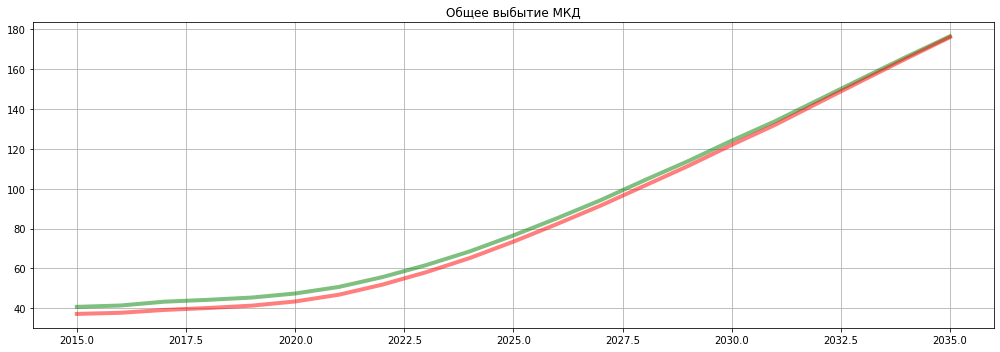

In [33]:
s   = fdf.loc['Total']
s2  = fdf2.loc['Total']
asa = s.plot.line(figsize=(14, 5), linewidth=4, alpha=0.5, title='Общее выбытие МКД', color='g')
bsa = s2.plot.line(ax=asa, linewidth=4, alpha=0.5, color='r', grid=True)
plt.tight_layout()
plt.show()